### Crate Tensorflow Estimator Class and Train it locally

In [1]:
PROJECT_ID = 'jchavezar-demo'
NUM_NEURONS = 32
L_RATE = 0.001
EPOCHS = 10
TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

In [2]:
from src import Estimator

VertexTF = Estimator.VertexTF(
    project_id=PROJECT_ID,
    epochs=10
)
train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)

In [3]:
## Prepare data by splitting, shuffling, transform to tensors, normalize and encode categorical values.

train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column='will_buy_on_return_visit')

2022-10-17 23:14:56.813836: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-17 23:14:56.816831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-17 23:14:56.816845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/jesusarguelles/code/vertex-gpu/pipe_notebook/src/data/Transform.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in datafram

In [6]:
model = VertexTF.create_model(nn_input=NUM_NEURONS, lr=L_RATE)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 medium (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 channelGrouping (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 deviceCategory (InputLayer)    [(None, 1)]          0           []                               
                                                                                              

In [ ]:
model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10


/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['will_buy_on_return_visit'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14325/14325 [==============================] - 19s 1ms/step - loss: 0.0577 - accuracy: 0.9847 - val_loss: 0.0534 - val_accuracy: 0.9846
Epoch 2/10
 7421/14325 [==============>...............] - ETA: 8s - loss: 0.0540 - accuracy: 0.9844

In [6]:
loss, accuracy = model.evaluate(test_ds)

1791/1791 [==============================] - 2s 929us/step - loss: 0.0578 - accuracy: 0.9855


In [7]:
train

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
54189,0,0,0,102,3,youtube.com,referral,Social,desktop,Serbia
419658,0,0,1,0,1,google,organic,Organic Search,mobile,(not set)
263645,0,0,0,4,2,google,organic,Organic Search,desktop,United States
134114,0,0,1,0,1,(direct),(none),Direct,mobile,United States
525196,0,0,1,0,1,google,organic,Organic Search,desktop,United Kingdom
...,...,...,...,...,...,...,...,...,...,...
228818,0,2,0,1908,12,mall.googleplex.com,referral,Referral,desktop,United States
122519,0,0,0,51,2,youtube.com,referral,Social,desktop,Vietnam
494629,0,0,1,0,1,(direct),(none),Direct,mobile,United States
516989,0,5,0,422,15,(direct),(none),Direct,desktop,United States


<AxesSubplot:>

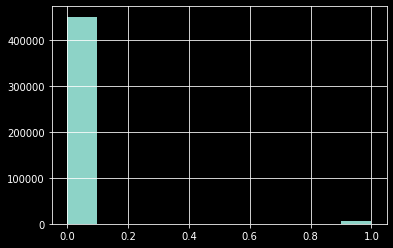

In [8]:
train['will_buy_on_return_visit'].hist()

### Create Container with Code and Train it with Vertex AI

In [1]:
TRAIN_IMAGE_URI = 'gcr.io/jchavezar-demo/visitor-purchase-train-ml:draft'
AIP_MODEL_DIR = 'gs://vtx-models/purchase/'
STAGING_DIR = 'gs://vtx-staging'

In [2]:
!rm -fr bqml_tf_keras
!mkdir bqml_tf_keras
!mkdir bqml_tf_keras/src
!cp -r src/* bqml_tf_keras/src/

In [3]:
%%writefile bqml_tf_keras/main.py
import os
import warnings
import argparse
from src import Estimator
warnings.filterwarnings('ignore')

TRAIN_START_DATE = "20160801"
TRAIN_END_DATE = "20170430"

def get_args():
    '''Parses args. Must include all hyperparameters you want to tune.'''
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--batch_size',
        default=32,
        type=int,
        help='batch size to build tf.data.Dataset')
    parser.add_argument(
        '--num_neurons',
        default=32,
        type=int,
        help='The number of neural neurons in the first layer'
        )
    parser.add_argument(
        '--learning_rate',
        default=0.001,
        type=float,
        help='number of units in the first hidden layer')
    parser.add_argument(
        '--epochs',
        default=10,
        type=int,
        help='The number of training iterations over the entire dataset'
        )
    parser.add_argument(
        '--label_column',
        default='will_buy_on_return_visit',
        type=str,
        help='The column to be predicted'
        )
    args = parser.parse_args()
    return args

def main():
    args = get_args()
    VertexTF = Estimator.VertexTF(
        project_id=os.environ['CLOUD_ML_PROJECT_ID'],
        epochs=args.epochs
        )
    train, val, test = VertexTF.query(start_date=TRAIN_START_DATE, end_date=TRAIN_END_DATE)
    train_ds, val_ds, test_ds = VertexTF.preprocessing(target_column=args.label_column)
    model = VertexTF.create_model(nn_input=args.num_neurons, lr=args.learning_rate)
    print(train_ds)
    history = model.fit(train_ds, epochs=args.epochs, validation_data=val_ds)

    hp_metric = history.history['val_accuracy'][-1]
    print(hp_metric)

    model.save(os.environ['AIP_MODEL_DIR'])

if __name__ == "__main__":
    main()

Writing bqml_tf_keras/main.py


In [4]:
%%writefile bqml_tf_keras/Dockerfile
FROM tensorflow/tensorflow

RUN pip install google-cloud-bigquery==2.34.4 \
    && pip install pandas \
    && pip install protobuf==3.19.4 \
    && pip install pyarrow \
    && pip install cloudml-hypertune

COPY . /

ENTRYPOINT ["python", "main.py"]

Writing bqml_tf_keras/Dockerfile


In [7]:
%%writefile bqml_tf_keras/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-9:latest

COPY . /

ENTRYPOINT ["python", "main.py"]

Overwriting bqml_tf_keras/Dockerfile


### Cloud Build to Create and Push Image to Google Cloud Repository

In [8]:
!gcloud builds submit -t $TRAIN_IMAGE_URI bqml_tf_keras/.

Creating temporary tarball archive of 13 file(s) totalling 23.6 KiB before compression.
Uploading tarball of [bqml_tf_keras/.] to [gs://jchavezar-demo_cloudbuild/source/1666065928.896624-204b1f5352a6411d91dcbe7d7b5a1c9b.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/d489e4f8-7f04-4419-b741-814aabf3cf53].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/d489e4f8-7f04-4419-b741-814aabf3cf53?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "d489e4f8-7f04-4419-b741-814aabf3cf53"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1666065928.896624-204b1f5352a6411d91dcbe7d7b5a1c9b.tgz#1666065929335820


### Run the Custom Training Job on Vertex AI

In [ ]:
from google.cloud.aiplatform import CustomJob

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4"
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,

        }
    } 
]

job = CustomJob(
    display_name = 'visitor-purchases',
    worker_pool_specs = worker_pool_specs,
    staging_bucket = STAGING_DIR,
    base_output_dir = AIP_MODEL_DIR
)
job.run()

Creating CustomJob
CustomJob created. Resource name: projects/569083142710/locations/us-central1/customJobs/2617359667252166656
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/569083142710/locations/us-central1/customJobs/2617359667252166656')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2617359667252166656?project=569083142710
CustomJob projects/569083142710/locations/us-central1/customJobs/2617359667252166656 current state:
JobState.JOB_STATE_QUEUED
CustomJob projects/569083142710/locations/us-central1/customJobs/2617359667252166656 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/2617359667252166656 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/2617359667252166656 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/26173596